# Hyperparameter Tuning

**Comprehensive guide to tuning hyperparameters for SFT, DPO, and RLHF**

## Why Hyperparameters Matter

Hyperparameters can make the difference between a model that:

- **Succeeds:** Converges smoothly, achieves strong performance, generalizes well
- **Fails:** Diverges, gets stuck, overfits, or forgets pre-training knowledge

```
Bad hyperparameters:  Loss: 2.5 -> 2.3 -> 2.4 -> 2.6 -> NaN
Good hyperparameters: Loss: 2.5 -> 1.8 -> 1.4 -> 1.2 -> 1.1
```

## Learning Rate

**The most important hyperparameter.** Too high -> instability. Too low -> slow convergence.

### Method-Specific Recommendations

**SFT (Supervised Fine-Tuning):**

| Setup | Learning Rate | Rationale |
|-------|--------------|----------|
| Full fine-tuning | 2e-5 to 5e-5 | Model already trained, small updates |
| LoRA (r=8-16) | 1e-4 to 5e-4 | LoRA params randomly initialized |
| LoRA (r=32-64) | 5e-5 to 2e-4 | Higher capacity, more stable |

**DPO (Direct Preference Optimization):**

| Setup | Learning Rate | Rationale |
|-------|--------------|----------|
| Full fine-tuning | 5e-6 to 2e-5 | Very sensitive to preference signal |
| LoRA (r=8-16) | 5e-5 to 2e-4 | Stronger updates for random init |

**RLHF (PPO):**

| Component | Learning Rate | Rationale |
|-----------|--------------|----------|
| Policy (full FT) | 1e-6 to 5e-6 | Extremely sensitive (RL) |
| Policy (LoRA) | 1e-5 to 5e-5 | LoRA more stable |
| Value network | 3e-5 to 1e-4 | Separate network, can train faster |

In [1]:
import torch
import numpy as np

def lr_range_test(model, dataloader, min_lr=1e-6, max_lr=1e-3, steps=100):
    """
    Run learning rate range test to find optimal LR.
    
    Tests exponentially increasing learning rates and plots loss.
    Optimal LR is typically where loss decreases fastest.
    """
    lrs = []
    losses = []
    
    # Exponentially increase LR
    lr_mult = (max_lr / min_lr) ** (1 / steps)
    lr = min_lr
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    for i, batch in enumerate(dataloader):
        if i >= steps:
            break
        
        # Forward pass
        loss = model(**batch).loss
        
        # Record
        lrs.append(lr)
        losses.append(loss.item())
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Increase learning rate
        lr *= lr_mult
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    # Find LR with steepest gradient
    gradients = np.gradient(losses)
    best_idx = np.argmin(gradients)
    optimal_lr = lrs[best_idx]
    
    print(f"Suggested learning rate: {optimal_lr:.2e}")
    return optimal_lr, lrs, losses

print("Learning Rate Range Test:")
print("  Run this to find optimal LR for your setup")

Learning Rate Range Test:
  Run this to find optimal LR for your setup


## Learning Rate Schedules

In [2]:
from transformers import (
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup
)

# Cosine decay (recommended)
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=100,
#     num_training_steps=1000,
# )

print("Learning Rate Schedule Options:")
print()
print("1. Cosine with Warmup (Recommended):")
print("   0-100 steps:    Linear warmup (0 -> peak_lr)")
print("   100-1000 steps: Cosine decay (peak_lr -> 0.1 * peak_lr)")
print()
print("2. Linear Decay:")
print("   0-100 steps:    Linear warmup")
print("   100-1000 steps: Linear decay to 0")
print()
print("Warmup Steps:")
print("  Rule of thumb: 5-10% of total training steps")
print("  Short training (1000 steps):  warmup = 50-100")
print("  Long training (100,000 steps): warmup = 2000-5000")

Learning Rate Schedule Options:

1. Cosine with Warmup (Recommended):
   0-100 steps:    Linear warmup (0 -> peak_lr)
   100-1000 steps: Cosine decay (peak_lr -> 0.1 * peak_lr)

2. Linear Decay:
   0-100 steps:    Linear warmup
   100-1000 steps: Linear decay to 0

Warmup Steps:
  Rule of thumb: 5-10% of total training steps
  Short training (1000 steps):  warmup = 50-100
  Long training (100,000 steps): warmup = 2000-5000


## Batch Size

**Effective batch size = batch_size x gradient_accumulation_steps x num_gpus**

| Method | Recommended Effective Batch | Typical Physical Batch |
|--------|---------------------------|----------------------|
| SFT | 32-128 | 8-16 per GPU |
| DPO | 16-64 | 4-8 per GPU |
| RLHF | 16-64 (rollout), 64-256 (PPO) | 4-8 per GPU |
| Reward Model | 32-64 | 8-16 per GPU |

In [3]:
# Batch size scaling with learning rate
def scale_learning_rate(base_lr, base_batch, new_batch, method='sqrt'):
    """
    Scale learning rate when changing batch size.
    
    Methods:
    - 'linear': LR scales proportionally with batch size
    - 'sqrt': LR scales with sqrt of batch size (more conservative)
    """
    if method == 'linear':
        return base_lr * (new_batch / base_batch)
    elif method == 'sqrt':
        return base_lr * np.sqrt(new_batch / base_batch)
    else:
        raise ValueError(f"Unknown method: {method}")

# Example
base_lr = 3e-4
base_batch = 32
new_batch = 64

new_lr = scale_learning_rate(base_lr, base_batch, new_batch, method='sqrt')
print(f"Base: batch={base_batch}, lr={base_lr}")
print(f"Scaled: batch={new_batch}, lr={new_lr:.2e}")

Base: batch=32, lr=0.0003
Scaled: batch=64, lr=4.24e-04


## DPO: Beta Parameter

**The key DPO hyperparameter.** Controls how strongly the model deviates from reference.

$$\mathcal{L}_{\text{DPO}} = -\log \sigma\left(\beta \left[\log \frac{\pi_\theta(y_w|x)}{\pi_{\text{ref}}(y_w|x)} - \log \frac{\pi_\theta(y_l|x)}{\pi_{\text{ref}}(y_l|x)}\right]\right)$$

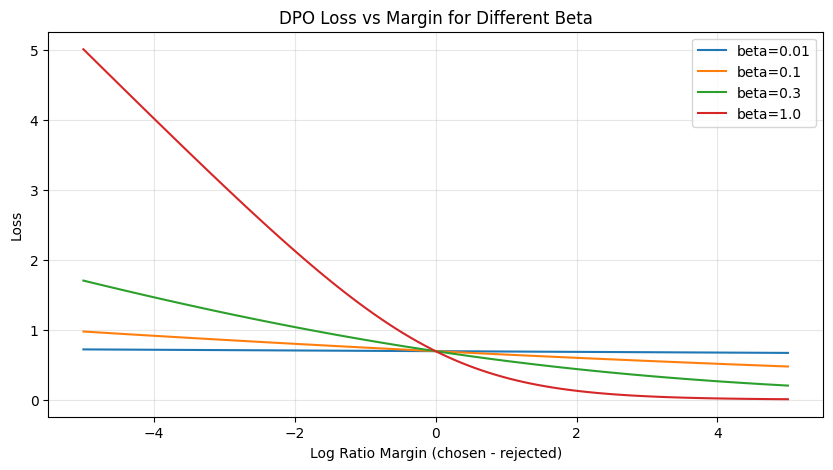

Beta Recommendations:
  beta=0.01:  Very weak, model changes little
  beta=0.1:   Standard (recommended)
  beta=0.3:   Strong preference signal
  beta=1.0:   Very strong, may overfit

Dataset Quality -> Beta:
  High (human annotated): 0.1-0.3
  Medium (AI labeled):    0.05-0.1
  Low (heuristic):        0.01-0.05


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize effect of beta
margin_range = np.linspace(-5, 5, 100)

plt.figure(figsize=(10, 5))
for beta in [0.01, 0.1, 0.3, 1.0]:
    logits = beta * margin_range
    loss = -np.log(1 / (1 + np.exp(-logits)))  # -log sigmoid
    plt.plot(margin_range, loss, label=f'beta={beta}')

plt.xlabel('Log Ratio Margin (chosen - rejected)')
plt.ylabel('Loss')
plt.title('DPO Loss vs Margin for Different Beta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Beta Recommendations:")
print("  beta=0.01:  Very weak, model changes little")
print("  beta=0.1:   Standard (recommended)")
print("  beta=0.3:   Strong preference signal")
print("  beta=1.0:   Very strong, may overfit")
print()
print("Dataset Quality -> Beta:")
print("  High (human annotated): 0.1-0.3")
print("  Medium (AI labeled):    0.05-0.1")
print("  Low (heuristic):        0.01-0.05")

## RLHF: KL Coefficient

**Controls how much the policy can deviate from reference model.**

$$\mathcal{L}_{\text{RLHF}} = \mathbb{E}\left[r(x,y) - \lambda_{\text{KL}} \cdot \text{KL}(\pi_\theta || \pi_{\text{ref}})\right]$$

In [5]:
class AdaptiveKLController:
    """Adaptive KL coefficient for RLHF."""
    
    def __init__(self, init_kl_coef=0.1, target_kl=0.01):
        self.kl_coef = init_kl_coef
        self.target_kl = target_kl
    
    def update(self, current_kl):
        """Adjust KL coefficient based on current KL."""
        if current_kl > 2 * self.target_kl:
            # KL too high, increase coefficient
            self.kl_coef *= 1.5
            print(f"Increasing KL coef to {self.kl_coef:.3f}")
        elif current_kl < 0.5 * self.target_kl:
            # KL too low, decrease coefficient
            self.kl_coef *= 0.8
            print(f"Decreasing KL coef to {self.kl_coef:.3f}")
        
        return self.kl_coef

print("KL Coefficient Recommendations:")
print("  kl_coef=0.01:  Policy can deviate significantly")
print("  kl_coef=0.1:   Balanced (recommended)")
print("  kl_coef=0.5:   Strong constraint")
print("  kl_coef=2.0:   Very constrained, minimal change")
print()
print("PPO Hyperparameters:")
print("  clip_epsilon=0.2:  Standard value")
print("  ppo_epochs=4:      Balanced sample efficiency")

KL Coefficient Recommendations:
  kl_coef=0.01:  Policy can deviate significantly
  kl_coef=0.1:   Balanced (recommended)
  kl_coef=0.5:   Strong constraint
  kl_coef=2.0:   Very constrained, minimal change

PPO Hyperparameters:
  clip_epsilon=0.2:  Standard value
  ppo_epochs=4:      Balanced sample efficiency


## LoRA: Rank and Alpha

In [6]:
# LoRA configuration guide
print("LoRA Rank Selection:")
print()
print("| Model Size | Task Complexity | Rank | Alpha |")
print("|------------|-----------------|------|-------|")
print("| <1B        | Simple          | 4-8  | 8-16  |")
print("| <1B        | Complex         | 8-16 | 16-32 |")
print("| 1B-7B      | Simple          | 8-16 | 16-32 |")
print("| 1B-7B      | Complex         | 16-32| 32-64 |")
print("| 7B+        | Complex         | 32-64| 64-128|")
print()
print("Standard relationship: alpha = 2 * rank")
print()
print("Effect of rank:")
print("  r=4:   ~0.1% trainable params, may underfit")
print("  r=8:   ~0.2% trainable params, good for simple tasks")
print("  r=16:  ~0.4% trainable params, standard choice")
print("  r=32:  ~0.8% trainable params, complex tasks")
print("  r=64:  ~1.6% trainable params, very complex")

LoRA Rank Selection:

| Model Size | Task Complexity | Rank | Alpha |
|------------|-----------------|------|-------|
| <1B        | Simple          | 4-8  | 8-16  |
| <1B        | Complex         | 8-16 | 16-32 |
| 1B-7B      | Simple          | 8-16 | 16-32 |
| 1B-7B      | Complex         | 16-32| 32-64 |
| 7B+        | Complex         | 32-64| 64-128|

Standard relationship: alpha = 2 * rank

Effect of rank:
  r=4:   ~0.1% trainable params, may underfit
  r=8:   ~0.2% trainable params, good for simple tasks
  r=16:  ~0.4% trainable params, standard choice
  r=32:  ~0.8% trainable params, complex tasks
  r=64:  ~1.6% trainable params, very complex


## Hyperparameter Cheat Sheet

In [7]:
# Quick reference configurations
print("="*60)
print("SFT (Supervised Fine-Tuning) - LoRA")
print("="*60)
print("""
SFTConfig(
    learning_rate=3e-4,              # Key parameter
    batch_size=8,                    # Fit to memory
    gradient_accumulation_steps=4,   # Effective batch = 32
    num_epochs=3,                    # 3-5 for most datasets
    warmup_steps=100,                # 5-10% of training
    max_grad_norm=1.0,               # Standard clipping
    weight_decay=0.01,               # Standard regularization
)""")

print("\n" + "="*60)
print("DPO (Direct Preference Optimization) - LoRA")
print("="*60)
print("""
DPOConfig(
    learning_rate=5e-5,              # Lower than SFT!
    beta=0.1,                        # DPO temperature
    batch_size=4,                    # Smaller (chosen+rejected)
    gradient_accumulation_steps=8,   # Effective batch = 32
    num_epochs=1,                    # Often sufficient
    warmup_steps=50,                 # Short warmup
    max_grad_norm=1.0,
)""")

print("\n" + "="*60)
print("RLHF (PPO) - LoRA")
print("="*60)
print("""
RLHFConfig(
    policy_lr=1e-5,                  # Very low for stability
    value_lr=5e-5,                   # Can be higher
    kl_coef=0.1,                     # KL penalty strength
    clip_epsilon=0.2,                # PPO clipping
    ppo_epochs=4,                    # Optimization epochs
    batch_size=4,                    # Small batches
    max_grad_norm=0.5,               # Stricter clipping
)""")

SFT (Supervised Fine-Tuning) - LoRA

SFTConfig(
    learning_rate=3e-4,              # Key parameter
    batch_size=8,                    # Fit to memory
    gradient_accumulation_steps=4,   # Effective batch = 32
    num_epochs=3,                    # 3-5 for most datasets
    warmup_steps=100,                # 5-10% of training
    max_grad_norm=1.0,               # Standard clipping
    weight_decay=0.01,               # Standard regularization
)

DPO (Direct Preference Optimization) - LoRA

DPOConfig(
    learning_rate=5e-5,              # Lower than SFT!
    beta=0.1,                        # DPO temperature
    batch_size=4,                    # Smaller (chosen+rejected)
    gradient_accumulation_steps=8,   # Effective batch = 32
    num_epochs=1,                    # Often sufficient
    warmup_steps=50,                 # Short warmup
    max_grad_norm=1.0,
)

RLHF (PPO) - LoRA

RLHFConfig(
    policy_lr=1e-5,                  # Very low for stability
    value_lr=5e-5,         

## Common Hyperparameter Mistakes

### Mistake 1: Using Same LR for All Methods
```python
# Bad: Same LR everywhere
sft_config = SFTConfig(learning_rate=3e-4)      # OK
dpo_config = DPOConfig(learning_rate=3e-4)      # Too high!
rlhf_config = RLHFConfig(policy_lr=3e-4)        # Way too high!

# Good: Method-specific LRs
sft_config = SFTConfig(learning_rate=3e-4)
dpo_config = DPOConfig(learning_rate=5e-5)
rlhf_config = RLHFConfig(policy_lr=1e-5)
```

### Mistake 2: Not Scaling LR for LoRA
```python
# Bad: Using full fine-tuning LR with LoRA
config = SFTConfig(learning_rate=3e-5)  # Too low for LoRA!

# Good: Higher LR for LoRA
config = SFTConfig(learning_rate=3e-4)  # 10x higher
```

### Mistake 3: No Warmup
```python
# Bad: No warmup (unstable start)
config = SFTConfig(warmup_steps=0)

# Good: 5-10% warmup
config = SFTConfig(warmup_steps=100)
```

## Summary

**Quick Start Hyperparameters:**

| Method | LR | Batch | Beta/KL | Epochs |
|--------|-----|-------|---------|--------|
| SFT (LoRA) | 3e-4 | 8x4 | - | 3 |
| DPO (LoRA) | 5e-5 | 4x8 | beta=0.1 | 1 |
| RLHF (LoRA) | 1e-5 | 4 | KL=0.1 | - |

**Tuning Priority:**
1. **Learning rate** (biggest impact)
2. **Batch size** (stability and speed)
3. **Method-specific** (beta, KL coefficient)
4. **Secondary** (warmup, weight decay, clipping)

## Next Steps

Now let's explore comprehensive evaluation metrics beyond loss.